<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 4)</h2>
        <img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>
    </div>
    <div style="padding: 3px 8px;">
        
1. **Description**:
   - **Idea**: k-mer Representation with One-Hot Encoding / embeding for Neural Network Architecture
   - Treat each k-mer (a sequence of k bases) as a single token.
   - Use one-hot encoding to represent each k-mer.
   - Train a neural network model on the sequence of one-hot encoded k-mers.

2. **Pros**:
   - Captures short-range dependencies and interactions between bases.
   - One-hot encoding is straightforward and easy to implement.
   - Neural networks can potentially learn complex patterns in the data.

3. **Cons**:
   - High dimensionality for larger k values, which can lead to increased computational cost.
   - May not capture long-range dependencies effectively without additional mechanisms like attention.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Flatten, Input
from keras.layers import LSTM, SimpleRNN, Bidirectional
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D
from keras import Model

import matplotlib.pyplot as plt
from Utils.VISU import VISU
import itertools

from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer

In [19]:
def read_fasta_file(file_path, family):
    """
    Utils: Convert fasta file to dataframe
    """
    sequences = []
    with open(file_path, 'r') as file:
        current_id = None
        current_sequence = ''
        for line in file:
            if line.startswith('>'):
                if current_id:
                    sequences.append({'id': current_id, 'sequence':current_sequence, 'length':len(current_sequence), 'class': family})
                current_id = line.strip().split('|')[0][1:].strip()
                current_sequence = ''
            else:
                current_sequence += line.strip()
        if current_id:
            sequences.append({'id': current_id, 'sequence':current_sequence, 'length':len(current_sequence), 'class': family})
    
    df = pd.DataFrame(sequences)
    return df

### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [20]:
dataset = pd.read_csv("./Output/Arabidopsis_thaliana_GHLH_and_CYP_gene.csv")
testset = read_fasta_file("./Content/Validation-set/LsbHLH.fasta", 0)
dataset.head()

,id,sequence,length,class
0,AT1G51140.1,AAGTTTCTCTCACGTTCTCTTTTTTAATTTTAATTTCTCGCCGGAA...,2297,0
1,AT1G73830.1,ACTTTCTATTTTCACCAATTTTCAAAAAAAAAATAAAAATTGAAAC...,1473,0
2,AT1G09530.1,AGTTACAGACGATTTGGTCCCCTCTCTTCTCTCTCTGCGTCCGTCT...,2958,0
3,AT1G49770.1,ATGACTAATGCTCAAGAGTTGGGGCAAGAGGGTTTTATGTGGGGCA...,2205,0
4,AT1G68810.1,AAACTTTTGTCTCTTTTTAACTCTCTTAACTTTCGTTTCTTCTCCT...,1998,0


### 3 - Preprocessing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>
        <span style="color: red;">Representation method 1</span> : Kmer-One-Hot-Encoding, one-dimensional representation of a single DNA sequence which consist of concatenation of k-mer one-hot-encoding
    </li></ul>
</h4>

In [30]:
def generate_kmers(k):
    """
    Generate all possible k-mers and return a mapping dictionary with one-hot encoded vectors.
    """
    kmers = [''.join(p) for p in itertools.product('ACGT', repeat=k)]
    one_hot_encoding = np.eye(len(kmers), dtype=int)
    kmer_dict = {kmer: one_hot_encoding[i] for i, kmer in enumerate(kmers)}
    return kmer_dict
    
def seq2kmer(sequence, k=3, sliding_windows=1, as_sentence=False, pad_length=None, pad_char='-'):
    """
    Convert a sequence to k-mers and return list of k-mers or a concatenated string of k-mers.
    """
    if pad_length:
        sequence = sequence.ljust(pad_length, pad_char)
        
    kmer_list = []
    for i in range(0, len(sequence) - k + 1, sliding_windows):
        kmer_list.append(sequence[i:i + k])
    if as_sentence:
        kmer_list = " ".join(kmer_list)
    return kmer_list

def vectorize(sequences, kmer_dict, k=3, step=1, max_pad=None):
    """
    Convert a sequence into a vector using k-mer one-hot encoding.
    """
    kmer_size = 4 ** k
    vector = []
    for seq in sequences:
        one_hot_vector = []
        for i in range(0, len(seq) - k + 1, step):
            try:
                one_hot_vector.extend(kmer_dict[seq[i:i + k]])
            except:
                one_hot_vector.extend([0]*kmer_size)
                
        vector.append(one_hot_vector)
    
    # Handling inequal sequence length using zero padding
    max_len = max_pad if max_pad != None else max(len(arr) for arr in vector)
    for i in range(len(vector)):
        required = max_len - len(vector[i])
        vector[i]+=([0]*required)
        vector[i] = np.array(vector[i])

    return np.array(vector)

In [31]:
k = 3
NUM_CLASS  = 1
kmer_dict = generate_kmers(k)
#SEQ_LENGTH = int(dataset['sequence'].apply(lambda x: len(x)).max())
X = vectorize(dataset['sequence'].tolist(), kmer_dict, k, max_pad=311744)
y = np.array(dataset['class'])
X_test = vectorize(testset['sequence'].tolist(), kmer_dict, k, max_pad=311744)
y_test = np.array(testset['class'])
SEQ_LENGTH = X.shape[1]

In [32]:
X

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [33]:
X_train = X
y_train = y
print("Shapes of train/test splits:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Shapes of train/test splits:
X_train: (380, 311744)
X_test: (122, 311744)
y_train: (380,)
y_test: (122,)


* Utils

In [34]:
def model_checkpoint(model_name):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/SeqEmbedding1D/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )
def plot_curve(history, list_of_metrics):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], '.-', label=m, lw=2, )
    plt.legend()

### 4 - Model training and testing

#### 4.1 MODEL 1 : FEED-FORWARD NETWORKS WITHOUT EMBEDDINGS

Model: "FEEDFORWARD1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 256)            │    79,806,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,847,937 (304.60 MB)

 Trainable params: 79,847,937 (304.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 814ms/step - accuracy: 0.6129 - loss: 0.6940 - val_accuracy: 0.6053 - val_loss: 0.6313
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 671ms/step - accuracy: 0.8598 - loss: 0.2899 - val_accuracy: 0.5395 - val_loss: 0.7606
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 480ms/step - accuracy: 0.9726 - loss: 0.1032 - val_accuracy: 0.6842 - val_loss: 0.6573
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 434ms/step - accuracy: 0.9826 - loss: 0.0468 - val_accuracy: 0.6711 - val_loss: 0.6357
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 426ms/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 0.6447 - val_loss: 0.6850
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.6579 - val_loss: 0.7349
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 407ms/step - accuracy: 1.0000 - loss: 8.7897e-04 - val_accuracy: 0.6579 - val_loss: 0.7837
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 427ms/step - accuracy: 1.0000 - loss: 5.5265e-04 - val_accuracy: 0.

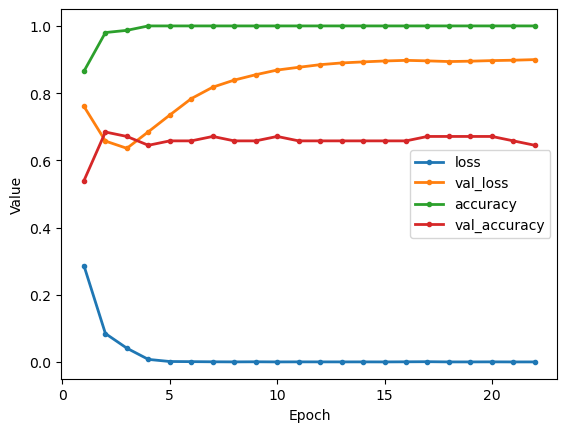

In [35]:
name="FEEDFORWARD1"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=5)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

#### 4.2 MODEL 2 : CONVOLUTIONAL NEURAL NETWORKS (CNN)

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 311742, 16)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 311741, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 311739, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 311738, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9975616)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 9975616)        │    39,902,464 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │     9,975,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,879,713 (190.28 MB)

 Trainable params: 29,928,481 (114.17 MB)

 Non-trainable params: 19,951,232 (76.11 MB)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 347s 73s/step - accuracy: 0.5766 - loss: 7.6569 - val_accuracy: 0.4211 - val_loss: 3.2640
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 267s 48s/step - accuracy: 0.8073 - loss: 16.2011 - val_accuracy: 0.5789 - val_loss: 5.1606
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 243s 52s/step - accuracy: 0.9108 - loss: 2.6588 - val_accuracy: 0.5789 - val_loss: 14.2908
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 315s 62s/step - accuracy: 0.9703 - loss: 0.7391 - val_accuracy: 0.5789 - val_loss: 16.7824
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 377s 73s/step - accuracy: 0.9963 - loss: 0.4303 - val_accuracy: 0.5789 - val_loss: 7.2759
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 283s 48s/step - accuracy: 0.9935 - loss: 0.0236 - val_accuracy: 0.5789 - val_loss: 1.7433
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 254s 49s/step - accuracy: 0.9502 - loss: 0.7868 - val_accuracy: 0.5789 - val_loss: 11.3315

[Train Accuracy: 95.72% - Test Accuracy: 0.00%]


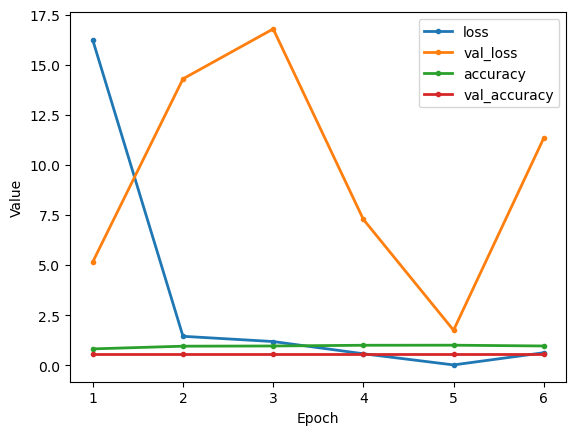

In [36]:
name="CNN"
def cnn(name=name, layers=2, filters=[16, 32, 64, 100], num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(seq_length,1)))

    for i in range(layers):
        model.add(Conv1D(filters=filters[i], kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2, strides=1))
    model.add(Flatten())

    model.add(BatchNormalization())
    model.add(Dense(num_output, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = cnn(layers=2)
stop_callback = early_stopping(patience=5)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>
        <span style="color: red;">Representation method 2</span> : DNA sequences as k-mer sentence and embedding
    </li></ul>
</h4>

In [47]:
model_performance = {}

* **Word2Vec**

In [77]:
k = 4
model_performance[k] = {
    'word2vec': [], 
    'dna2vec':  [], 
}
NUM_CLASS  = 1
X = dataset['sequence'].apply(lambda seq: seq2kmer(seq, k=k, as_sentence=True))
y = np.array(dataset['class'])

In [78]:
X_test = testset['sequence'].apply(lambda seq: seq2kmer(seq, k=k, as_sentence=True))
y_test = np.array(testset['class'])

In [79]:
X.head()

0    AAGT AGTT GTTT TTTC TTCT TCTC CTCT TCTC CTCA T...
1    ACTT CTTT TTTC TTCT TCTA CTAT TATT ATTT TTTT T...
2    AGTT GTTA TTAC TACA ACAG CAGA AGAC GACG ACGA C...
3    ATGA TGAC GACT ACTA CTAA TAAT AATG ATGC TGCT G...
4    AAAC AACT ACTT CTTT TTTT TTTG TTGT TGTC GTCT T...
Name: sequence, dtype: object

In [80]:
# Train Word2Vec model
w2v_model = Word2Vec(sentences=[sequence.split() for sequence in X.tolist()], vector_size=100, window=5, min_count=1, workers=4)
word_index = w2v_model.wv.key_to_index
word_index = {key: value + 1 for key, value in word_index.items()}

In [81]:
# Prepare the embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in w2v_model.wv.key_to_index.keys():
        embedding_matrix[i] = w2v_model.wv[w2v_model.wv.key_to_index[word]]

In [82]:
# Prepare the data for the neural network
def texts_to_sequences(texts, word_index):
        sequences = []
        for text in texts:
            seq = []
            for word in text.split():
                index = word_index.get(word)
                if index is not None:
                    seq.append(index)
            sequences.append(seq)
        return sequences

# text to seq
X = texts_to_sequences(X.tolist(), word_index)
X_test = texts_to_sequences(X_test.tolist(), word_index)

# padding
SEQ_LENGTH = max(max(len(seq) for seq in X), max(len(seq) for seq in X_test))
X = pad_sequences(X, maxlen=SEQ_LENGTH)
X_test = pad_sequences(X_test, maxlen=SEQ_LENGTH)

In [83]:
# Train test split - we do not need to make train test split as we already have the two dataset separated
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

X_train = X
y_train = y
print("Shapes of train/test splits:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Shapes of train/test splits:
X_train: (380, 4870)
X_test: (122, 4870)
y_train: (380,)
y_test: (122,)


**1. FEED FORWARD MODEL**

Model: "FF-SIMPLE-EMBEDDING"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 4870)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_10 (Embedding)        │ (None, 4870, 100)      │        25,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 487000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │   124,672,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,730,981 (475.81 MB)

 Trainable params: 124,705,281 (475.71 MB)

 Non-trainable params: 25,700 (100.39 KB)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5155 - loss: 1.7434 - val_accuracy: 0.6053 - val_loss: 0.9336
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 589ms/step - accuracy: 0.7357 - loss: 9.5560 - val_accuracy: 0.7368 - val_loss: 1.4686
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step - accuracy: 0.8016 - loss: 9.0848 - val_accuracy: 0.6974 - val_loss: 2.4170
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 909ms/step - accuracy: 0.8311 - loss: 9.6787 - val_accuracy: 0.7237 - val_loss: 2.8680
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 698ms/step - accuracy: 0.8861 - loss: 6.9101 - val_accuracy: 0.6842 - val_loss: 3.6288
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - accuracy: 0.9351 - loss: 5.2163 - val_accuracy: 0.6842 - val_loss: 4.4198
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step - accuracy: 0.9301 - loss: 3.7704 - val_accuracy: 0.6711 - val_loss: 4.9490
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step - accuracy: 0.9273 - loss: 4.7702 - val_accuracy: 0.6711 - val

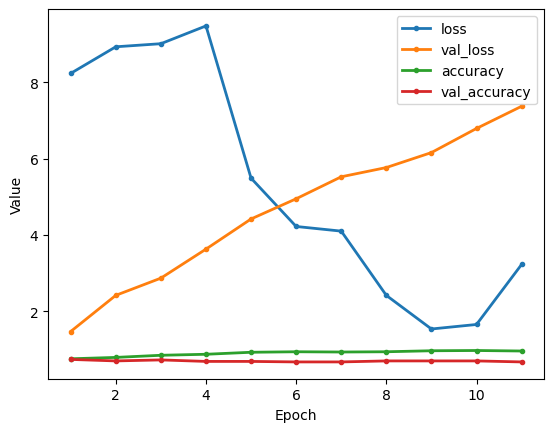

In [84]:
name="FF-SIMPLE-EMBEDDING"
def model1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH, embedding_matrix=embedding_matrix):
    # embedding layer
    embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, trainable=False)
    embedding_layer.build((1,))
    embedding_layer.set_weights([embedding_matrix])

    # input layer
    int_sequences_input = Input(shape=(seq_length,), dtype="int32")

    # stacked layer
    embedded_sequences = embedding_layer(int_sequences_input)
    x = Flatten()(embedded_sequences)
    x = Dense(256, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    #x = Dense(64, activation='relu')(x)
    #x = Dropout(rate=0.5)(x)
    pred = Dense(num_output, activation='sigmoid')(x)
    model = Model(int_sequences_input, pred, name=name)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = model1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

# Save model performance for report
model_performance[k]['word2vec'].append(scores[1]*100)

**2. CNN MODEL**

Model: "CNN-SIMPLE-EMBEDDING"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 4870)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_11 (Embedding)        │ (None, 4870, 100)      │        25,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 4870, 64)       │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 2435, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2435, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 155840)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │       155,841 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,061 (785.39 KB)

 Trainable params: 175,233 (684.50 KB)

 Non-trainable params: 25,828 (100.89 KB)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.5363 - loss: 10.2701 - val_accuracy: 0.6184 - val_loss: 2.0695
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.7388 - loss: 3.6123 - val_accuracy: 0.6316 - val_loss: 3.2583
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.7096 - loss: 2.6641 - val_accuracy: 0.6184 - val_loss: 5.6415
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.8313 - loss: 1.5958 - val_accuracy: 0.6974 - val_loss: 3.8462
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.8966 - loss: 0.6714 - val_accuracy: 0.6974 - val_loss: 6.1062
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.9608 - loss: 0.2022 - val_accuracy: 0.6579 - val_loss: 7.3024
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.9439 - loss: 0.2445 - val_accuracy: 0.6711 - val_loss: 3.4817
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.9989 - loss: 0.0035 - val_accuracy: 0.6711 - 

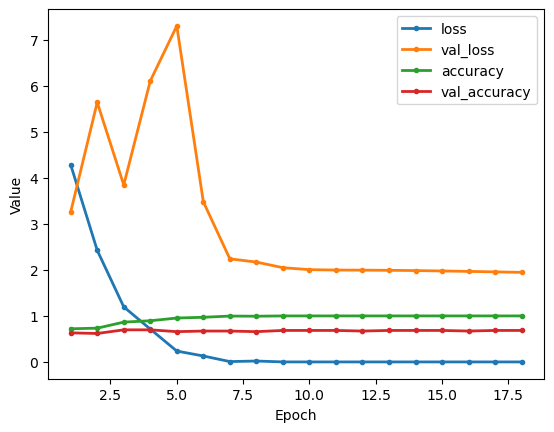

In [85]:
name="CNN-SIMPLE-EMBEDDING"
def model2(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH, embedding_matrix=embedding_matrix):
    # embedding layer
    embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, trainable=False)
    embedding_layer.build((1,))
    embedding_layer.set_weights([embedding_matrix])

    # input layer
    int_sequences_input = Input(shape=(seq_length,), dtype="int32")
    # stacked layer
    embedded_sequences = embedding_layer(int_sequences_input)
    x = Conv1D(filters=16, kernel_size=3, padding='same', activation="relu")(embedded_sequences)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=32, kernel_size=3, padding='same', activation="relu")(embedded_sequences)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=64, kernel_size=3, padding='same', activation="relu")(embedded_sequences)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    pred = Dense(num_output, activation='sigmoid')(x)
    model = Model(int_sequences_input, pred, name=name)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = model2()
stop_callback = early_stopping(patience=15)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

# Save model performance for report
model_performance[k]['word2vec'].append(scores[1]*100)

**3. LSTM**

Model: "LSTM-SIMPLE-EMBEDDING"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 4870)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_12 (Embedding)        │ (None, 4870, 100)      │        25,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,201 (414.85 KB)

 Trainable params: 80,501 (314.46 KB)

 Non-trainable params: 25,700 (100.39 KB)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.5305 - loss: 0.6998 - val_accuracy: 0.5000 - val_loss: 0.7347
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.6132 - loss: 0.6354 - val_accuracy: 0.5263 - val_loss: 0.7356
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.7364 - loss: 0.5534 - val_accuracy: 0.4868 - val_loss: 0.7328
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.8038 - loss: 0.4956 - val_accuracy: 0.5000 - val_loss: 0.7372
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.8262 - loss: 0.4722 - val_accuracy: 0.4737 - val_loss: 0.7420
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.8487 - loss: 0.4387 - val_accuracy: 0.4605 - val_loss: 0.7497
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.8762 - loss: 0.3995 - val_accuracy: 0.4737 - val_loss: 0.7605
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.9114 - loss: 0.3586 - val_accuracy: 0.5000 - val_loss: 0.7717


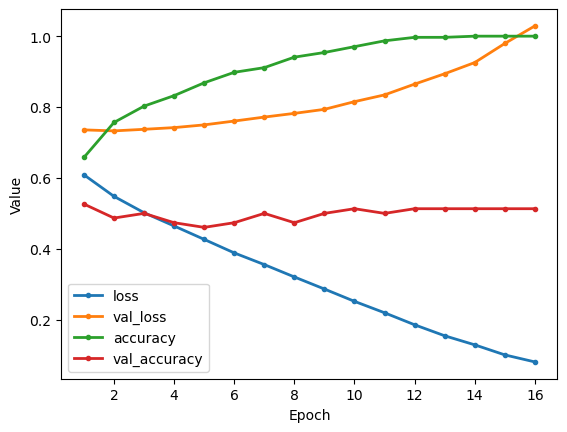

In [86]:
name="LSTM-SIMPLE-EMBEDDING"
def model3(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH, embedding_matrix=embedding_matrix):
    # embedding layer
    embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, trainable=False)
    embedding_layer.build((1,))
    embedding_layer.set_weights([embedding_matrix])

    # input layer
    int_sequences_input = Input(shape=(seq_length,), dtype="int32")

    # stacked layer
    embedded_sequences = embedding_layer(int_sequences_input)
    x = LSTM(100)(embedded_sequences)
    pred = Dense(num_output, activation='sigmoid')(x)
    model = Model(int_sequences_input, pred, name=name)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = model3()
stop_callback = early_stopping(patience=15)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

# Save model performance for report
model_performance[k]['word2vec'].append(scores[1]*100)

**4. LSTM AND CNN**

Model: "CNN_BiLSTM-SIMPLE-EMBEDDING"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 4870)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_13 (Embedding)        │ (None, 4870, 100)      │        25,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 4870, 32)       │         9,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 2435, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 200)            │       106,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,933 (554.43 KB)

 Trainable params: 116,233 (454.04 KB)

 Non-trainable params: 25,700 (100.39 KB)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5579 - loss: 0.6947 - val_accuracy: 0.5526 - val_loss: 0.6964
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6212 - loss: 0.6731 - val_accuracy: 0.5000 - val_loss: 0.6970
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6350 - loss: 0.6462 - val_accuracy: 0.5263 - val_loss: 0.6975
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5994 - loss: 0.6331 - val_accuracy: 0.5000 - val_loss: 0.7012
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7195 - loss: 0.5985 - val_accuracy: 0.4868 - val_loss: 0.7091
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7334 - loss: 0.5635 - val_accuracy: 0.5263 - val_loss: 0.7172
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7918 - loss: 0.5213 - val_accuracy: 0.5395 - val_loss: 0.7231
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7685 - loss: 0.4792 - val_accuracy: 0.5789 - val_loss: 0.7474


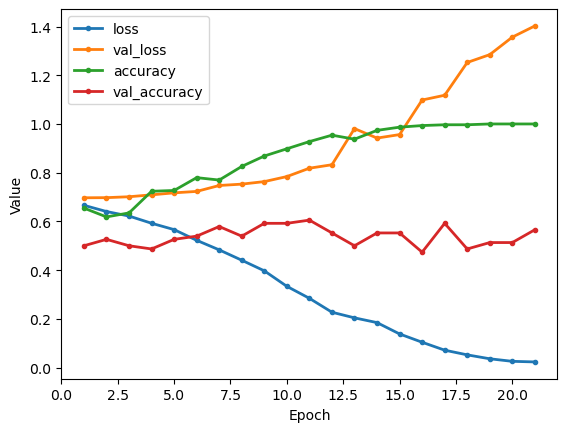

In [87]:
name="CNN_BiLSTM-SIMPLE-EMBEDDING"
def model4(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH, embedding_matrix=embedding_matrix):
    # embedding layer
    embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, trainable=False)
    embedding_layer.build((1,))
    embedding_layer.set_weights([embedding_matrix])

    # input layer
    int_sequences_input = Input(shape=(seq_length,), dtype="int32")

    # stacked layer
    embedded_sequences = embedding_layer(int_sequences_input)
    x = Conv1D(filters=32, kernel_size=3, padding='same', activation="relu")(embedded_sequences)
    x = MaxPooling1D(pool_size=2)(x)
    x = Bidirectional(LSTM(100))(x)
    pred = Dense(num_output, activation='sigmoid')(x)
    model = Model(int_sequences_input, pred, name=name)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = model4()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

# Save model performance for report
model_performance[k]['word2vec'].append(scores[1]*100)

* **Dna2Vec embedding**

In [88]:
# load pretrained model to use embedding representation of k-mer

from Transfer_Learning.dna2vec.multi_k_model import MultiKModel
filepath = 'Transfer_Learning/dna2vec/pretrained/dna2vec-20161219-0153-k3to8-100d-10c-29320Mbp-sliding-Xat.w2v'
mk_model = MultiKModel(filepath)

In [89]:
# Prepare the embedding matrix
embedding_dim = 100
embedding_matrix_pretrain = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in w2v_model.wv.key_to_index.keys():
        embedding_matrix_pretrain[i] = mk_model.vector(word)

**1. FEED FORWARD MODEL**

Model: "FF-DNA2VEC-EMBEDDING"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 4870)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_14 (Embedding)        │ (None, 4870, 100)      │        25,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 487000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │   124,672,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,730,981 (475.81 MB)

 Trainable params: 124,705,281 (475.71 MB)

 Non-trainable params: 25,700 (100.39 KB)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 992ms/step - accuracy: 0.5393 - loss: 4.7133 - val_accuracy: 0.4342 - val_loss: 2.7968
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6321 - loss: 2.1115 - val_accuracy: 0.6842 - val_loss: 0.9657
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 517ms/step - accuracy: 0.8273 - loss: 0.8362 - val_accuracy: 0.6053 - val_loss: 2.4048
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 422ms/step - accuracy: 0.8759 - loss: 0.6359 - val_accuracy: 0.6447 - val_loss: 1.0064
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 541ms/step - accuracy: 0.8918 - loss: 0.5301 - val_accuracy: 0.6711 - val_loss: 2.3826
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - accuracy: 0.9527 - loss: 0.3152 - val_accuracy: 0.6711 - val_loss: 1.8967
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 673ms/step - accuracy: 0.9732 - loss: 0.0914 - val_accuracy: 0.6842 - val_loss: 1.0935
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 603ms/step - accuracy: 0.9847 - loss: 0.1007 - val_accuracy: 0.6974 - val_

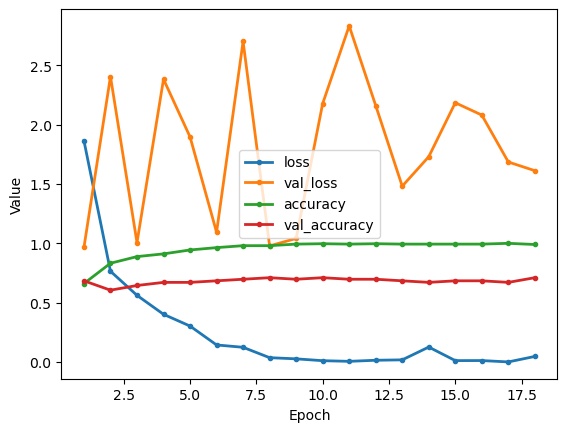

In [90]:
name="FF-DNA2VEC-EMBEDDING"
def model1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH, embedding_matrix=embedding_matrix):
    # embedding layer
    embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, trainable=False)
    embedding_layer.build((1,))
    embedding_layer.set_weights([embedding_matrix])

    # input layer
    int_sequences_input = Input(shape=(seq_length,), dtype="int32")

    # stacked layer
    embedded_sequences = embedding_layer(int_sequences_input)
    x = Flatten()(embedded_sequences)
    x = Dense(256, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    #x = Dense(64, activation='relu')(x)
    #x = Dropout(rate=0.2)(x)
    pred = Dense(num_output, activation='sigmoid')(x)
    model = Model(int_sequences_input, pred, name=name)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = model1(embedding_matrix=embedding_matrix_pretrain)
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

# Save model performance for report
model_performance[k]['dna2vec'].append(scores[1]*100)

**2. CNN MODEL**

Model: "CNN-DNA2VEC-EMBEDDING"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 4870)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_15 (Embedding)        │ (None, 4870, 100)      │        25,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 4870, 64)       │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 2435, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2435, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 155840)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │       155,841 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,061 (785.39 KB)

 Trainable params: 175,233 (684.50 KB)

 Non-trainable params: 25,828 (100.89 KB)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.5131 - loss: 8.1902 - val_accuracy: 0.5526 - val_loss: 0.7415
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.6092 - loss: 4.9623 - val_accuracy: 0.6447 - val_loss: 1.1057
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.7639 - loss: 2.8469 - val_accuracy: 0.6184 - val_loss: 0.6669
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.7379 - loss: 1.6064 - val_accuracy: 0.6711 - val_loss: 0.6081
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.9791 - loss: 0.0625 - val_accuracy: 0.6316 - val_loss: 0.6253
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.9429 - loss: 0.1521 - val_accuracy: 0.6447 - val_loss: 0.6312
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 1.0000 - loss: 0.0168 - val_accuracy: 0.6974 - val_loss: 0.6410
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.5658 - v

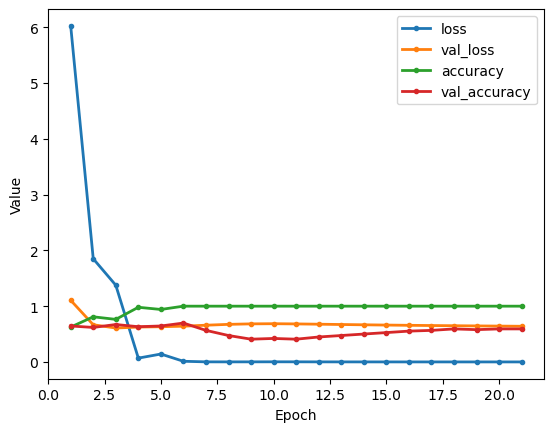

In [91]:
name="CNN-DNA2VEC-EMBEDDING"
def model2(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH, embedding_matrix=embedding_matrix):
    # embedding layer
    embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, trainable=False)
    embedding_layer.build((1,))
    embedding_layer.set_weights([embedding_matrix])

    # input layer
    int_sequences_input = Input(shape=(seq_length,), dtype="int32")

    # stacked layer
    embedded_sequences = embedding_layer(int_sequences_input)
    x = Conv1D(filters=16, kernel_size=3, padding='same', activation="relu")(embedded_sequences)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=32, kernel_size=3, padding='same', activation="relu")(embedded_sequences)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=64, kernel_size=3, padding='same', activation="relu")(embedded_sequences)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    pred = Dense(num_output, activation='sigmoid')(x)
    model = Model(int_sequences_input, pred, name=name)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = model2(embedding_matrix=embedding_matrix_pretrain)
stop_callback = early_stopping(patience=15)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

# Save model performance for report
model_performance[k]['dna2vec'].append(scores[1]*100)

**3. LSTM**

Model: "LSTM-DNA2VEC-EMBEDDING"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 4870)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_16 (Embedding)        │ (None, 4870, 100)      │        25,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,201 (414.85 KB)

 Trainable params: 80,501 (314.46 KB)

 Non-trainable params: 25,700 (100.39 KB)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.5347 - loss: 0.6894 - val_accuracy: 0.5658 - val_loss: 0.6841
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.5593 - loss: 0.6734 - val_accuracy: 0.5789 - val_loss: 0.6854
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.5787 - loss: 0.6679 - val_accuracy: 0.4868 - val_loss: 0.6862
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.6226 - loss: 0.6474 - val_accuracy: 0.5395 - val_loss: 0.6860
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.6307 - loss: 0.6315 - val_accuracy: 0.4605 - val_loss: 0.6889
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.6285 - loss: 0.6166 - val_accuracy: 0.4474 - val_loss: 0.6977
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.6506 - loss: 0.5978 - val_accuracy: 0.4079 - val_loss: 0.7141
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.6841 - loss: 0.5786 - val_accuracy: 0.3947 - val_loss: 0.7281


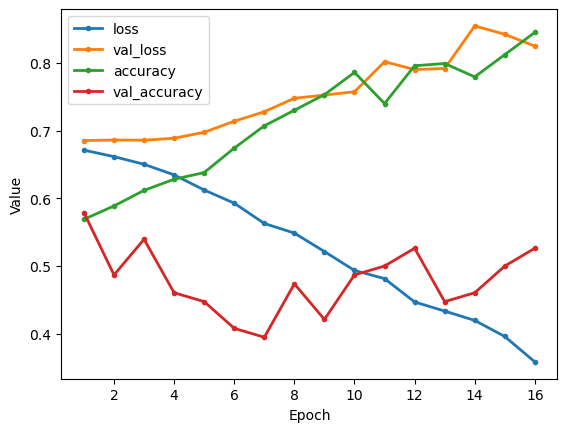

In [92]:
name="LSTM-DNA2VEC-EMBEDDING"
def model3(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH, embedding_matrix=embedding_matrix):
    # embedding layer
    embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, trainable=False)
    embedding_layer.build((1,))
    embedding_layer.set_weights([embedding_matrix])

    # input layer
    int_sequences_input = Input(shape=(seq_length,), dtype="int32")

    # stacked layer
    embedded_sequences = embedding_layer(int_sequences_input)
    x = LSTM(100)(embedded_sequences)
    pred = Dense(num_output, activation='sigmoid')(x)
    model = Model(int_sequences_input, pred, name=name)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = model3(embedding_matrix=embedding_matrix_pretrain)
stop_callback = early_stopping(patience=15)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

# Save model performance for report
model_performance[k]['dna2vec'].append(scores[1]*100)

**4. LSTM AND CNN**

Model: "CNN_BiLSTM-DNA2VEC-EMBEDDING"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 4870)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_17 (Embedding)        │ (None, 4870, 100)      │        25,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 4870, 32)       │         9,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 2435, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 200)            │       106,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,933 (554.43 KB)

 Trainable params: 116,233 (454.04 KB)

 Non-trainable params: 25,700 (100.39 KB)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5147 - loss: 0.6942 - val_accuracy: 0.5789 - val_loss: 0.6842
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6096 - loss: 0.6672 - val_accuracy: 0.5789 - val_loss: 0.6829
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5458 - loss: 0.6874 - val_accuracy: 0.5789 - val_loss: 0.6851
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5526 - loss: 0.6767 - val_accuracy: 0.5789 - val_loss: 0.6845
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5801 - loss: 0.6660 - val_accuracy: 0.5789 - val_loss: 0.6830
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5341 - loss: 0.6705 - val_accuracy: 0.5789 - val_loss: 0.6835
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5943 - loss: 0.6426 - val_accuracy: 0.5658 - val_loss: 0.6840
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6284 - loss: 0.6121 - val_accuracy: 0.5789 - val_loss: 0.6776


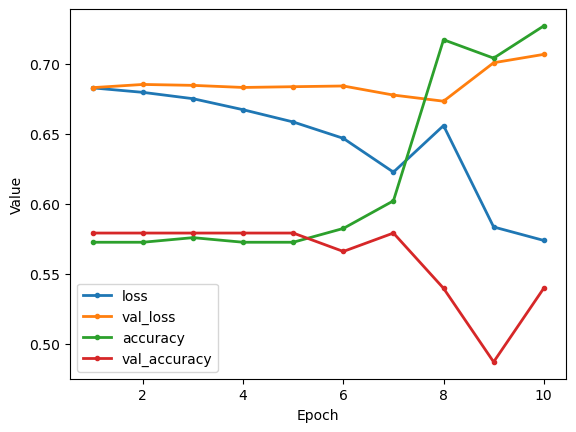

In [93]:
name="CNN_BiLSTM-DNA2VEC-EMBEDDING"
def model4(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH, embedding_matrix=embedding_matrix):
    # embedding layer
    embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, trainable=False)
    embedding_layer.build((1,))
    embedding_layer.set_weights([embedding_matrix])

    # input layer
    int_sequences_input = Input(shape=(seq_length,), dtype="int32")

    # stacked layer
    embedded_sequences = embedding_layer(int_sequences_input)
    x = Conv1D(filters=32, kernel_size=3, padding='same', activation="relu")(embedded_sequences)
    x = MaxPooling1D(pool_size=2)(x)
    x = Bidirectional(LSTM(100))(x)
    pred = Dense(num_output, activation='sigmoid')(x)
    model = Model(int_sequences_input, pred, name=name)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = model4(embedding_matrix=embedding_matrix_pretrain)
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

# Save model performance for report
model_performance[k]['dna2vec'].append(scores[1]*100)

* SAVE IN DATAFRAME

In [94]:
def performance_to_dataframe(model_performance):
    data = []
    for k, performance in model_performance.items():
        for model_type, accuracies in performance.items():
            for accuracy in accuracies:
                data.append({'k': k, 'model_type': model_type, 'accuracy': accuracy})
    df = pd.DataFrame(data)
    return df

# Convert the model performance dictionary to a DataFrame
df = performance_to_dataframe(model_performance)
df.to_csv(f'./Output/Embedding/result_k_{k}.csv', index=False)

# Print the DataFrame
df

,k,model_type,accuracy
0,3,word2vec,57.894737
1,3,word2vec,57.894737
2,3,word2vec,57.894737
3,3,word2vec,57.894737
4,3,dna2vec,57.894737
5,3,dna2vec,57.894737
6,3,dna2vec,57.894737
7,3,dna2vec,57.894737
8,4,word2vec,57.894737
9,4,word2vec,57.894737


* <span style="color: blue;">Let's summarize the result</span>

In [95]:
fs_result_k3 = pd.read_csv("./Output/Embedding/result_k_3.csv")
fs_result_k4 = pd.read_csv("./Output/Embedding/result_k_4.csv")
fs_result_k5 = pd.read_csv("./Output/Embedding/result_k_5.csv")
fs_result_k6 = pd.read_csv("./Output/Embedding/result_k_6.csv")

FileNotFoundError: [Errno 2] No such file or directory: './Output/Embedding/result_k_5.csv'

In [ ]:
df = pd.DataFrame({
    'k3_word2vec': fs_result_k3[fs_result_k3['model_type'] == "word2vec"]["accuracy"].values,
    'k3_pretrain': fs_result_k3[fs_result_k3['model_type'] == "dna2vec"]["accuracy"].values,
    'k4_word2vec': fs_result_k4[fs_result_k4['model_type'] == "word2vec"]["accuracy"].values,
    'k4_pretrain': fs_result_k4[fs_result_k4['model_type'] == "dna2vec"]["accuracy"].values,
    'k5_word2vec': fs_result_k5[fs_result_k5['model_type'] == "word2vec"]["accuracy"].values,
    'k5_pretrain': fs_result_k5[fs_result_k5['model_type'] == "dna2vec"]["accuracy"].values,
    'k6_word2vec': fs_result_k6[fs_result_k6['model_type'] == "word2vec"]["accuracy"].values,
    'k6_pretrain': fs_result_k6[fs_result_k6['model_type'] == "dna2vec"]["accuracy"].values,
})

iterable = [["k=3", "k=4", "k=5", "k=6"], ["word2vec", "dna2vec"]]
index = pd.MultiIndex.from_product(iterable, names=["k_mer", "accuracy per embedding method "])
df.index = ["FEED FORWARD MODEL", "CNN MODEL", "LSTM MODEL", "LSTM-CNN MODEL"]
df.columns = index

# Highlight best performance for each model
def highlight_best_scores(s):
    is_max = s == s.max()
    return ['font-weight:bold; color: red' if v else '' for v in is_max]

df_style = df.style.apply(highlight_best_scores, axis=1)
display(df_style)

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>
        <span style="color: red;">Representation method 3</span> : k-mer Pretrained Transformer based DNABERT
    </li></ul>
</h4>

Paper: 
- https://academic.oup.com/bioinformatics/article/37/15/2112/6128680
- https://github.com/jerryji1993/DNABERT